In [1]:
# imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import math
%matplotlib inline

In [25]:
def undistort_single(img):
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted

def undistort(testImages, plot=False, save=False):
    result = []
    for fName in testImages:
        img = mpimg.imread(fName)
        undistorted = undistort_single(img)
        result.append(undistorted)
        fNameShort = fName.split('/')[2]
        if plot:            
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(img)
            ax1.set_title('Original ' + fNameShort, fontsize=40)
            ax2.imshow(undistorted)
            ax2.set_title('Undistorted ' + fNameShort, fontsize=40)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        if save:           
            [fn, extension] = fNameShort.split('.')
            outputPath = 'output_images/' + fn + '_undistorted.png'
            mpimg.imsave(outputPath, img)
    return result

In [3]:
# camera calibration
images = glob.glob('./camera_cal/calibration*.jpg')

nX = 9
nY = 6

objpoints = []
imgpoints = []
validationImages = [] # use images that did not contain expected chessboard grid as validation images

objp = np.zeros((nY*nX,3),np.float32)
objp[:,:2] = np.mgrid[0:nX,0:nY].T.reshape(-1,2)

for fName in images:
    
    img = mpimg.imread(fName)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nX,nY), None)

    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    else:
        validationImages.append(fName)

# test result on images not used for calibration
undistort(validationImages);

In [15]:
# distortion correction on raw images

# read in test_images
testImages = glob.glob('./test_images/*.jpg')

# undistort and save to output folder
undistort(testImages, save=True);


In [5]:
# perspective transformation - helper function

import matplotlib.lines as mlines

def transform_perspective(img, plot=False):
    
    yHighSrc = 456
    yLowSrc = 678
    x1Src = 275
    x2Src = 587
    x3Src = 699
    x4Src = 1046
    
    if plot:
        f, ax = plt.subplots(figsize=(24, 9))
        f.tight_layout()
        ax.imshow(img)
        plt.plot(x2Src, yHighSrc, '.') # upper left
        plt.plot(x3Src, yHighSrc, '.') # upper right
        plt.plot(x4Src, yLowSrc, '.') # lower right
        plt.plot(x1Src, yLowSrc, '.') # lower left
        l1 = mlines.Line2D([x1Src,x2Src], [yLowSrc,yHighSrc])
        l2 = mlines.Line2D([x3Src,x4Src], [yHighSrc,yLowSrc])
        ax.add_line(l1)
        ax.add_line(l2)
        plt.show()

    src = np.float32([[x2Src,yHighSrc],[x3Src,yHighSrc],[x4Src,yLowSrc],[x1Src,yLowSrc]])

    yHighDst = 0
    yLowDst = img.shape[0]
    xLowDst = np.int32((x1Src + x2Src)/2)
    xHighDst = np.int32((x3Src + x4Src)/2)
    
    dst = np.float32([[xLowDst,yHighDst],[xHighDst,yHighDst],[xHighDst,yLowDst],[xLowDst,yLowDst]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        
    return warped, M, Minv


In [6]:
def invert_perspective_transform(img, Minv, img_size):
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=(cv2.INTER_LINEAR))    
    return unwarped

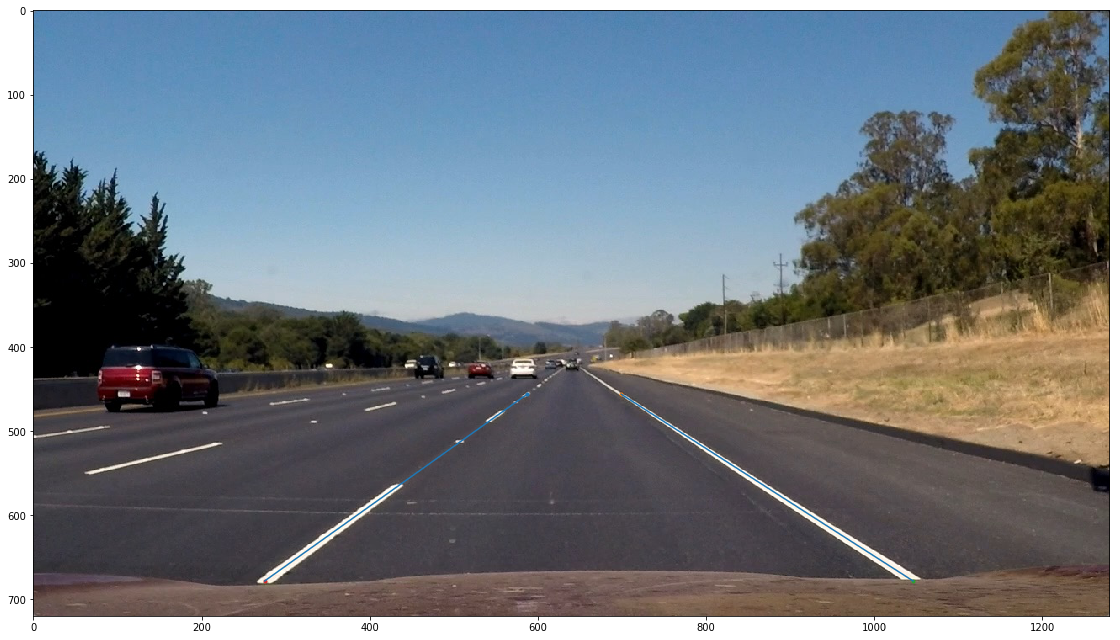

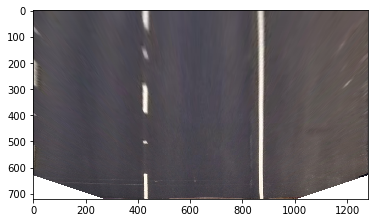

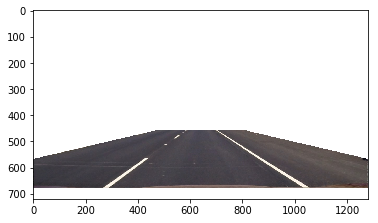

In [7]:
# test perspective transformation and inversion

img = mpimg.imread('./output_images/straight_lines2_undistorted.png')
[imagePerspectiveTransformed, M, Minv] = transform_perspective(img, plot=True)
plt.imshow(imagePerspectiveTransformed)
plt.show()

img_size = (img.shape[1], img.shape[0])
unwarped = invert_perspective_transform(imagePerspectiveTransformed, Minv, img_size)
plt.imshow(unwarped)
plt.show()

In [23]:
# perspective transform test images

# read in undistorted test images
testImages = glob.glob('./output_images/*_undistorted.png')

# perspective transform and save to ouput folder
for fName in testImages:
    img = mpimg.imread(fName)
    [imagePerspectiveTransformed, M, Minv] = transform_perspective(img)
    outputPath = fName.replace('_undistorted', '_perspective_transformed')
    mpimg.imsave(outputPath, imagePerspectiveTransformed)

In [9]:
# helper functions

def colorGradient(image):
    
    r_channel = image[:,:,0]
    
    # Define thresholds
    s_thresh=(170, 255)
    r_thresh=(120, 255)
    sx_thresh=(30, 100)

    # Convert to HLS color space
    img = np.copy(image)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Take the derivative in x 
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) 
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
       
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold s channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold r channel
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1   
    
    # return combined channels
    return r_binary & (sxbinary | s_binary)

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def gaussian_blur(img):
    kernel_size = 5
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [10]:
def find_midpoint_and_bases(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return midpoint, leftx_base, rightx_base

def find_lane_pixels(binary_warped):
    [midpoint, leftx_base, rightx_base] = find_midpoint_and_bases(binary_warped)
        
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # HYPERPARAMETERS
    nwindows = 9 # number of sliding windows
    margin = 100 # set the width of the windows +/- margin
    minpix = 50 # minimum number of pixels found to recenter window

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),
#         (win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),
#         (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) & 
        (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if (good_left_inds.size > minpix):
            leftx_current = np.mean(nonzerox[good_left_inds], dtype=np.int)
        if (good_right_inds.size > minpix):
            rightx_current = np.mean(nonzerox[good_right_inds], dtype=np.int)

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##

    # color area between poly fit
    h, w = out_img.shape[:2]
    points1 = np.array([[[xi, yi]] for xi, yi in zip(left_fitx, ploty) if (0<=xi<w and 0<=yi<h)]).astype(np.int32)
    points2 = np.array([[[xi, yi]] for xi, yi in zip(right_fitx, ploty) if (0<=xi<w and 0<=yi<h)]).astype(np.int32)
    points2 = np.flipud(points2)
    points = np.concatenate((points1, points2))

    # polynomialgon = img.copy()
    cv2.fillPoly(out_img, [points], color=[0,255,0])
#     cv2.imshow('Polygon defined by two polynomials', out_img)
#     cv2.waitKey(0)

    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Plots the left and right polynomials on the lane lines
#     fig = plt.figure()
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    
#     # save result
#     plt.imshow(out_img)
#     fig.savefig('output_images/test3_poly_fit.png')

    return out_img, ploty, left_fitx, right_fitx


In [11]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def measure_curvature_real(ploty, left_fitx, right_fitx):
    ploty = ploty*ym_per_pix
    left_fit_cr = np.polyfit(ploty, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty, right_fitx*xm_per_pix, 2)
       
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    ##### calculation of R_curve (radius of curvature) #####
    aleft = left_fit_cr[0]
    bleft = left_fit_cr[1]
    aright = right_fit_cr[0]
    bright = right_fit_cr[1]
    left_curverad = ((1+(2*aleft*y_eval+bleft)**2)**(3/2))/np.absolute(2*aleft)
    right_curverad = ((1+(2*aright*y_eval+bright)**2)**(3/2))/np.absolute(2*aright)
    
    return left_curverad, right_curverad

def calculate_offset(binary_warped):
    [midpoint, leftx_base, rightx_base] = find_midpoint_and_bases(binary_warped)
    lane_center = (leftx_base+rightx_base)/2
    offset = (midpoint-lane_center)*xm_per_pix
    return offset

In [26]:
def pipeline(image):
    
    # undistort
    imageUndistorted = undistort_single(image)
    
    # color and gradient selection
    imageCs = colorGradient(imageUndistorted)
#     plt.imshow(imageCs, cmap='gray')
#     plt.show()

    # gaussian smoothing
    imageBlur = gaussian_blur(imageCs)
#     plt.imshow(imageBlur, cmap='gray')
#     plt.show()

    # perspective transformation
    [imagePerspectiveTransformed, M, Minv] = transform_perspective(imageBlur)
#     plt.imshow(imagePerspectiveTransformed, cmap='gray')
#     plt.show()
    
    # fit polynomial    
    [imagePolyFit, ploty, left_fitx, right_fitx] = fit_polynomial(imagePerspectiveTransformed)
#     plt.imshow(imagePolyFit)
#     plt.show()

    # Calculate the radius of curvature in meters for both lane lines
    left_curverad, right_curverad = measure_curvature_real(ploty, left_fitx, right_fitx)
    print(left_curverad, 'm', right_curverad, 'm')    
    
    # calculate offset
    offset = calculate_offset(imagePerspectiveTransformed)
    print(offset, 'm')
    
    # invert perspective transformation for detected lane lines    
    img_size = (image.shape[1], image.shape[0])
    inverted = invert_perspective_transform(imagePolyFit, Minv, img_size)
#     plt.imshow(inverted)
#     plt.show()
    
    # create overlay
    imageOverlay = weighted_img(inverted, image)
    plt.imshow(imageOverlay)
    plt.show()
    
    return imagePolyFit


1304.23300211 m 1637.26849106 m
-0.148 m


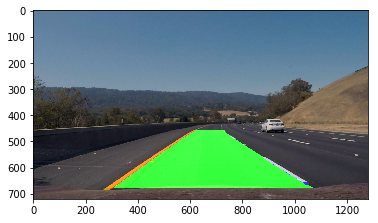

932.81478731 m 744.298025523 m
-0.274857142857 m


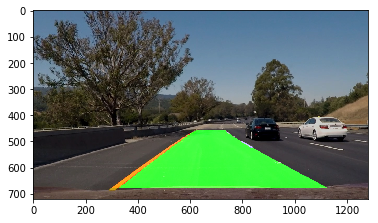

857.507422869 m 2600.44659296 m
-0.195571428571 m


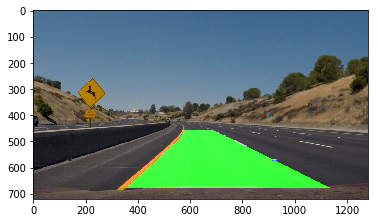

992.71758991 m 981.397283849 m
-0.0422857142857 m


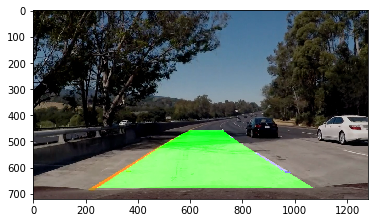

2100.05051692 m 700.066913772 m
-0.211428571429 m


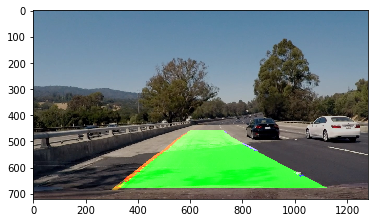

5903.86706615 m 86988.349823 m
-0.0475714285714 m


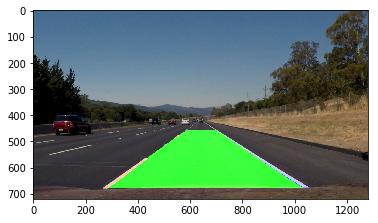

15951.7801681 m 9055.2116736 m
-0.0211428571429 m


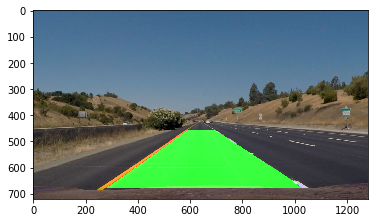

1020.4442282 m 1255.84981846 m
-0.224642857143 m


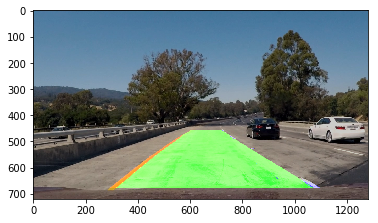

In [28]:
# read in test_images
testImages = glob.glob('./test_images/*.jpg')

for fName in testImages:
    img = mpimg.imread(fName)
#     plt.imshow(img)
#     plt.show()
    result = pipeline(img)

# mpimg.imsave('output_images/test3_poly_fit.png', result)
